In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf

# Import and inspect data

## Import

In [55]:
def import_data():
    """Import training and testing data, as data and labels"""
    
    # Import in pandas (np.genfromtxt is too slow)
    tr_pd = pd.read_csv('../week_2/data_train.csv', header=None)
    tst_pd = pd.read_csv('../week_2/data_test.csv', header=None)
    
    # Split data and labels
    tr_data = np.array(tr_pd.loc[:, 1:])
    tr_labels = np.array(tr_pd.loc[:, 0])
    tst_data = np.array(tst_pd.loc[:, 1:])
    tst_labels = np.array(tst_pd.loc[:, 0])
    
    return tr_data, tst_data, tr_labels, tst_labels

In [59]:
g_tr_data, g_tst_data, g_tr_labels, g_tst_labels = import_data()
g_tr_data = g_tr_data/255
g_tst_data = g_tst_data/255

## Inspect

In [60]:
def inspect_number(data, img_nums):
    """Display image. img_nums should be entered as list."""
    
    num_images = len(img_nums)
    # Reshape datasets into pixel array
    data_rs = np.reshape(data, newshape=(data.shape[0], 28, 28))
    
    figsize = (10, 100)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    for k in range(num_images):
        ax = axes[img_nums[k]]
        ax.imshow(data_rs[img_nums[k]], cmap='Greys')
        ax.set_axis_off()
    plt.show()

# Build VAE in Tensorflow

In [139]:
class AutoEncoder():
    """Autoencoder. For most examples, self.inp=self.tgt, but these are considered 
    independent variables to make extensions more straightforward."""
    
    def __init__(self, num_z, learn_param):
        self.batch_size = 100
        self.num_z = num_z    # Number of dimensions of latent space
        self.learn_param = learn_param
        
        self.inp = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='inputs')
        self.tgt = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='targets')
        self.sess = tf.Session()
        self._build_graph()
        self.sess.run(tf.initializers.global_variables())
    
    def _build_graph(self):
        """Build neural network"""
        initializer = tf.glorot_uniform_initializer()
        
        # Encoder: convolutional neural network
        enc_h = tf.layers.dense(self.inp, 256, kernel_initializer=initializer, 
                            activation=tf.nn.sigmoid, name='enc_dense1')
        enc_h = tf.layers.dense(enc_h, 128, kernel_initializer=initializer, 
                            activation=tf.nn.sigmoid, name='enc_dense2')
        enc_h = tf.layers.dense(enc_h, 64, kernel_initializer=initializer, 
                            activation=tf.nn.sigmoid, name='enc_dense3')
        self.mu = tf.layers.dense(enc_h, self.num_z, kernel_initializer=initializer,
                                  activation=None, name='enc_mu')
        self.log_sigma = tf.layers.dense(enc_h, self.num_z, kernel_initializer=initializer,
                                         activation=None, name='enc_log_sigma')
        self.z = tf.add(self.mu, 
                        tf.multiply(tf.exp(0.5 * self.log_sigma), 
                                    tf.random.normal(shape=[tf.shape(self.mu)[0], 
                                                            self.num_z]),
                        name='encoder_z'))

        # Decoder
        dec_h = tf.layers.dense(self.z, 64, kernel_initializer=initializer, 
                            activation=tf.nn.relu, name='decoder_1')
        dec_h = tf.layers.dense(dec_h, 128, kernel_initializer=initializer, 
                            activation=tf.nn.relu, name='decoder_2')
        dec_h = tf.layers.dense(dec_h, 256, kernel_initializer=initializer, 
                            activation=tf.nn.relu, name='decoder_3')
        self.out = tf.layers.dense(dec_h, 784, kernel_initializer=initializer, 
                                   activation=tf.nn.sigmoid, name='decoder_4')  
    
        # Optimizer: sum of generation loss and KL divergence
        self.loss_gen = -tf.reduce_sum(self.tgt * tf.log(1e-10 + self.out) + \
                                       (1 - self.tgt) * tf.log(1e-10 + 1 - self.out), 
                           axis=1)
        self.loss_KL = \
            0.5 * tf.reduce_sum(tf.square(self.mu) + tf.square(tf.exp(self.log_sigma)) - \
                                tf.log(tf.square(tf.exp(self.log_sigma))) - 1, axis=1)
        self.cost = tf.reduce_mean(tf.add(self.loss_gen, self.loss_KL))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.learn_param).minimize(self.cost)
        
    def make_minibatch(self, data_inp, data_tgt, batch_num):
        """Form a minibatch from the data"""
        llim = batch_num * self.batch_size
        rlim = (batch_num + 1) * self.batch_size
        return data_inp[llim:rlim], data_tgt[llim:rlim]
    
    def evaluate_AE_outputs(self, data_inp, data_tgt):
        """Run the autoencoder on some data and evaluate the mean squared error"""
        feed_dict = {self.inp: data_inp, self.tgt: data_tgt}
        z, outputs, cost = self.sess.run([self.z, self.out, self.cost], feed_dict=feed_dict)
        return z, outputs, cost

    def estimate_plots(self, data_inp, img_nums):
        """Plot the autoencoder estimates over some images"""
        self.run_size = data_inp.shape[0]
        estimates = self.evaluate_AE_outputs(data_inp[img_nums], data_inp[img_nums])[1]
        # print(np.round(estimates[0, :10], 20))   # For debugging
        inspect_number(estimates, img_nums)
        
    def plot_z(self, data_z, data_labels):
        """Plot z values in 2-space (if z-space is 2-dimensional)"""
        fig, ax = plt.subplots()
        for label in range(10):
            data = data_z[data_labels == label]
            ax.scatter(data[:, 0], data[:, 1])
        plt.show()
    
    def train_iteration(self, data_inp, data_tgt):
        """Do one training iteration over the input data"""
        self.run_size = data_inp.shape[0]
        feed_dict = {self.inp: data_inp, self.tgt: data_tgt}
        _, out = self.sess.run([self.optimizer, self.out], feed_dict=feed_dict)
        
    def train_full(self, tr_inp, tr_tgt, tst_inp, tst_tgt, num_epochs, 
                   info=True, infoplots=False):
        """Train neural network and keep track of progress by (cross) validating"""
        
        # batch_size must divide num_tr_points
        num_tr_pts = tr_inp.shape[0]
        num_tst_pts = tst_inp.shape[0]
        num_batches = int(round(num_tr_pts / self.batch_size)) 
        
        # Train the MLP and keep track of the errors across training and testing datasets
        batch_nums, epochs, tr_costs, tst_costs = \
                np.array([]), np.array([]), np.array([]), np.array([])
        for epoch in range(num_epochs):
            for batch_num in range(num_batches):
                # Input proportion correctly identified across training, testing dataset
                if batch_num % 600 == 0:
                    tr_z, tr_out, tr_cost = self.evaluate_AE_outputs(tr_inp, tr_tgt)
                    tst_z, tst_out, tst_cost = self.evaluate_AE_outputs(tst_inp, tst_tgt)
#                    self.plot_z(tr_z, g_tr_labels)
                    if info is True:
                        print('Cost after {} batches: Tr {}, Tst {}'.format(
                            batch_num, tr_cost, tst_cost))
#                    if infoplots is True: 
#                        self.estimate_plots(g_tr_data, np.arange(10))
                    epochs = np.append(epochs, epoch)
                    batch_nums = np.append(batch_nums, batch_num)
                    tr_costs = np.append(tr_costs, tr_cost)
                    tst_costs = np.append(tst_costs, tst_cost)
                
                # Do the training over a minibatch
                mb_tr_inp, mb_tr_tgt = \
                    self.make_minibatch(tr_inp, tr_tgt, batch_num=batch_num) 
                self.train_iteration(mb_tr_inp, mb_tr_tgt)    # Single training iteration
                
        if infoplots is True:
            for k in range(10):
                self.estimate_plots(g_tr_data, np.arange(10))
#            self.plot_z(tr_z, g_tr_labels)
                
        costs = pd.DataFrame(np.vstack((epochs, batch_nums, tr_costs, tst_costs)).T, 
                             columns = ['epoch', 'batch', 'train', 'test'])
        return costs

# Train model and evaluate

In [140]:
def train_AutoEncoder(tr_data, tst_data, num_z, num_epochs):
    inspect_number(tr_data, np.arange(10))
    model = AutoEncoder(num_z=num_z, learn_param=0.01)
    costs = model.train_full(tr_data, tr_data, tst_data, tst_data, num_epochs, 
                                 info=True, infoplots=True)

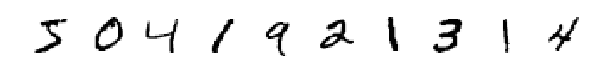

Cost after 0 batches: Tr 544.5900268554688, Tst 544.6026000976562
Cost after 0 batches: Tr 185.40968322753906, Tst 185.00018310546875
Cost after 0 batches: Tr 179.30189514160156, Tst 178.5490264892578


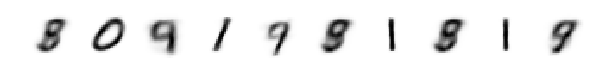

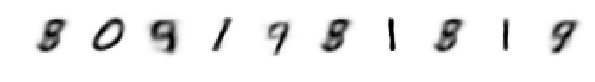

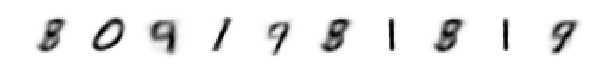

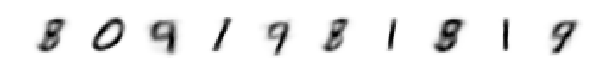

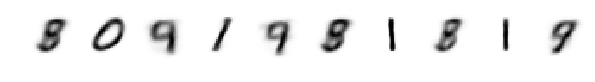

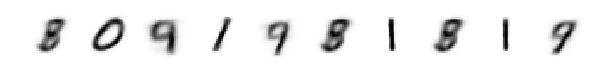

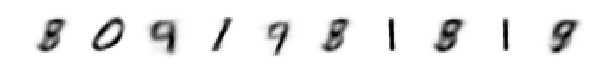

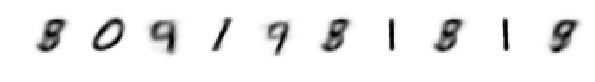

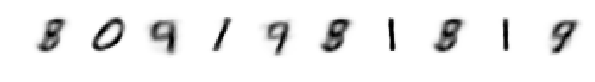

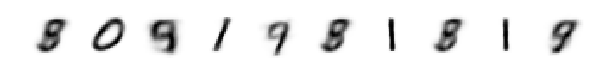

In [141]:
tf.reset_default_graph()
train_AutoEncoder(g_tr_data, g_tst_data, num_z=2, num_epochs=3)